# Twitter üzerinde Duygu Analizi
Yunus Emre Gündoğmuş - 6 Eylül 2021

### Referanslar
- [How to Scrape Tweets From Twitter](https://towardsdatascience.com/how-to-scrape-tweets-from-twitter-59287e20f0f1)
- [Savaş Yıldırım - Bert-base Turkish Sentiment Model](https://huggingface.co/savasy/bert-base-turkish-sentiment-cased)

### Kütüphalerin İçeri Alınması

In [ ]:
!pip install transformers
!pip install tweepy
!pip install tqdm

In [1]:
# Twitter API
import tweepy

# Data Manipulation
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

# Bert Model
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

In [ ]:
consumer_keys, consumer_secrets, access_tokens, access_token_secrets

### Twitter API Ayarlarının Yapılması

In [3]:
# API için Keyler
# API link: https://developer.twitter.com/en/apps

consumer_key = "xxxx"
consumer_secret = "xxxx"
access_token = "xxxx"
access_token_secret = "xxx"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

### Korona Anahtar kelimesindeki 100 tweet'in çekilmesi

In [4]:
tweets_list = []
text_query = 'Korona'
count = 100

for tweet in api.search(q=text_query, count=count, lang='tr-tr'):
    tweets_list.append((tweet.created_at,tweet.id,tweet.text))

In [5]:
tweets = pd.DataFrame(tweets_list, columns=["Tarih",'Tweet_id','Text'])
tweets.head()

,Tarih,Tweet_id,Text
0,2020-05-21 13:24:37,1263460690444062722,RT @trdusuncekulubu: KORONA VİRÜS FIRSAT MI?\n...
1,2020-05-21 13:24:34,1263460678800748545,RT @1Kirazkizi: Bir ramazanı daha bitirdiniz. ...
2,2020-05-21 13:24:32,1263460671146123266,"HDP milletvekili Dilşat Canbaz, TJA, TUHAY-DER..."
3,2020-05-21 13:24:23,1263460630809448451,@bra716 @HBC53 Korona seni çok tehlikeli bi ha...
4,2020-05-21 13:24:13,1263460591815065601,Dr. İbrahim Uslu: ❝Korona süreciyle birlikte t...


### Eğitilmiş BERT Modeli Kullanarak Duygu Analizinin Yapılması

In [6]:
# Eğitilmiş Ağırlıkların Yüklenmesi
model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

sentiment_analysis_pipeline= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)

In [36]:
sentiment_analysis_pipeline("Çok güzel bir film olduğunu düşünüyorum")

[{'label': 'LABEL_1', 'score': 0.9875534}]

In [8]:
sentiment_result=[]
for text in tqdm(tweets.Text):
    result = sentiment_analysis_pipeline(text)[0]
    sentiment_result.append(result)

100%|████████████| 100/100 [00:23<00:00,  4.34it/s]


In [9]:
sentiment_result = pd.DataFrame(sentiment_result)
sentiment_result.head()

,label,score
0,LABEL_1,0.805984
1,LABEL_1,0.824013
2,LABEL_0,0.768402
3,LABEL_1,0.987426
4,LABEL_1,0.748325


In [10]:
sentiment_result = pd.DataFrame(sentiment_result)
tweets = pd.concat([tweets, sentiment_result],axis=1)
tweets.label = tweets.label.map({'LABEL_1':1,'LABEL_0':0})
tweets.head()

,Tarih,Tweet_id,Text,label,score
0,2020-05-21 13:24:37,1263460690444062722,RT @trdusuncekulubu: KORONA VİRÜS FIRSAT MI?\n...,1,0.805984
1,2020-05-21 13:24:34,1263460678800748545,RT @1Kirazkizi: Bir ramazanı daha bitirdiniz. ...,1,0.824013
2,2020-05-21 13:24:32,1263460671146123266,"HDP milletvekili Dilşat Canbaz, TJA, TUHAY-DER...",0,0.768402
3,2020-05-21 13:24:23,1263460630809448451,@bra716 @HBC53 Korona seni çok tehlikeli bi ha...,1,0.987426
4,2020-05-21 13:24:13,1263460591815065601,Dr. İbrahim Uslu: ❝Korona süreciyle birlikte t...,1,0.748325


### Hepsini Bir araya Getirelim

In [11]:
class TwitterSentimentAnalyser:
    def __init__(self, consumer_key, consumer_secret, access_token, access_token_secret, keyword, tweetCount):
        self.keyword = keyword
        self.consumer_key = consumer_key
        self.consumer_secret = consumer_secret
        self.access_token = access_token
        self.access_token_secret = access_token_secret
        self.tweetCount = tweetCount
        
    def getTwitterData(self):
        tweets_list = []
        
        for tweet in api.search(q=self.keyword, count=self.tweetCount, lang='tr-tr'):
            tweets_list.append((tweet.created_at,tweet.id,tweet.text))
            
        self.tweets = pd.DataFrame(tweets_list, columns=["Tarih",'Tweet_id','Text'])
            
    def bertPipeline(self):
        # Eğitilmiş Ağırlıkların Yüklenmesi
        model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
        tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

        self.sentiment_analysis_pipeline= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)
        
    def sentimentPrediction(self):
        self.sentiment_result=[]
        for text in tqdm(self.tweets.Text):
            result = sentiment_analysis_pipeline(text)[0]
            self.sentiment_result.append(result)
        
        self.sentiment_result = pd.DataFrame(self.sentiment_result)
        self.tweets = pd.concat([self.tweets, self.sentiment_result],axis=1)
        self.tweets.label = self.tweets.label.map({'LABEL_1':1,'LABEL_0':0})

In [26]:
twst = TwitterSentimentAnalyser(consumer_key = consumer_keys, consumer_secret = consumer_secrets,
                                access_token = access_tokens, access_token_secret = access_token_secrets,
                                keyword='dolar', tweetCount=100)

In [27]:
twst.getTwitterData()
twst.tweets.head()

,Tarih,Tweet_id,Text
0,2020-05-21 14:25:43,1263476068142452736,RT @ugurses: AK Parti iktidara geldiğinde Aral...
1,2020-05-21 14:25:37,1263476044071346180,RT @eha_medya: 📍BAE bölgedeki başarısız askeri...
2,2020-05-21 14:25:35,1263476035565359107,RT @ademyarslan: 500 bin liralık rüşveti bilme...
3,2020-05-21 14:25:34,1263476028707610624,RT @alpertan66: İşbilya’da (Sevilla) 700 yıl s...
4,2020-05-21 14:25:24,1263475987070750720,Çerezlik 1500 dolar aldım bakalım ne kadar düş...


In [28]:
twst.bertPipeline()

In [29]:
twst.sentimentPrediction()
twst.tweets.head()

100%|████████████| 100/100 [00:31<00:00,  3.16it/s]


,Tarih,Tweet_id,Text,label,score
0,2020-05-21 14:25:43,1263476068142452736,RT @ugurses: AK Parti iktidara geldiğinde Aral...,1,0.901227
1,2020-05-21 14:25:37,1263476044071346180,RT @eha_medya: 📍BAE bölgedeki başarısız askeri...,0,0.987927
2,2020-05-21 14:25:35,1263476035565359107,RT @ademyarslan: 500 bin liralık rüşveti bilme...,0,0.940648
3,2020-05-21 14:25:34,1263476028707610624,RT @alpertan66: İşbilya’da (Sevilla) 700 yıl s...,1,0.907677
4,2020-05-21 14:25:24,1263475987070750720,Çerezlik 1500 dolar aldım bakalım ne kadar düş...,0,0.999318


In [33]:
print(f"{twst.keyword} Hakkında {twst.tweets.Tarih.min()} ile {twst.tweets.Tarih.max()} arasında atılan Tweetlerin Pozitiflik Oranı: {twst.tweets.label.mean()}")

dolar Hakkında 2020-05-21 14:16:33 ile 2020-05-21 14:25:43 arasında atılan Tweetlerin Pozitiflik Oranı: 0.46


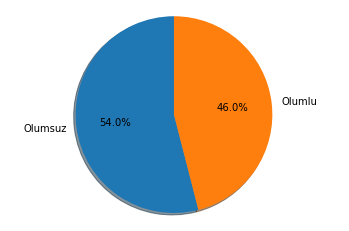

In [31]:
import matplotlib.pyplot as plt

labels = twst.tweets.label.map({1:'Olumlu',0:'Olumsuz'}).value_counts().index.values
sizes = twst.tweets.label.value_counts().values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()